# Version lineal

In [1]:
import math
import pandas as pd
import numpy as np
from itertools import combinations

from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Binary, NonNegativeReals,
    Objective, Constraint, value, summation
)
from pyomo.opt import SolverFactory
import os 


In [ ]:
import pandas as pd
import numpy as np

RADIUS_M = 3.2
BIG_M    = 1e6
write_adj_file = True

F_SPECIES = "species_targets.csv"
F_W       = "W_matrix.csv"
F_NODES   = "nodes_144.csv"
F_ADJ     = "adjacency.csv"
F_OUT     = "assignments.csv"

SPECIES_IDS = [
    "AG_LEC","AG_SAL","AG_SCB","AG_STR",
    "OP_CAN","OP_ENG","OP_ROB","OP_STR",
    "PR_LAE","YU_FIL"
]

VTOL_MIN = 0.0
VTOL_MAX = 0.25

species_df = pd.read_csv(F_SPECIES)
nodes_df   = pd.read_csv(F_NODES)
W_df       = pd.read_csv(F_W)

required_species_cols = {"species_id","f_target","v_tol"}
if not required_species_cols.issubset(set(species_df.columns)):
    raise ValueError(f"[species_targets.csv] Debe contener columnas: {sorted(required_species_cols)}")

species_df = species_df.copy()
species_df["species_id"] = species_df["species_id"].astype(str).str.strip()
species_df["f_target"]   = pd.to_numeric(species_df["f_target"], errors="raise")
species_df["v_tol"]      = pd.to_numeric(species_df["v_tol"],   errors="raise")

missing_spec = set(SPECIES_IDS) - set(species_df["species_id"])
extra_spec   = set(species_df["species_id"]) - set(SPECIES_IDS)
if missing_spec or extra_spec:
    raise ValueError(f"[species_targets.csv] Especies no alineadas.\n"
                     f"Faltan: {sorted(missing_spec)}\nSobran: {sorted(extra_spec)}")

species_df = species_df.set_index("species_id").loc[SPECIES_IDS].reset_index()

sum_f = float(species_df["f_target"].sum())
if sum_f <= 0:
    raise ValueError("[species_targets.csv] f_target debe sumar > 0.")
species_df["f_target"] = species_df["f_target"] / sum_f


species_df["v_tol"] = species_df["v_tol"].clip(lower=VTOL_MIN, upper=VTOL_MAX)


required_nodes_cols = {"node_id","x","y","status","species_id"}
if not required_nodes_cols.issubset(set(nodes_df.columns)):
    raise ValueError(f"[nodes.csv] Debe contener columnas: {sorted(required_nodes_cols)}")

nodes_df = nodes_df.copy()

nodes_df["status"]     = nodes_df["status"].astype(str).str.lower().str.strip()
nodes_df["species_id"] = nodes_df["species_id"].fillna("").astype(str).str.strip()
nodes_df["x"] = pd.to_numeric(nodes_df["x"], errors="coerce")
nodes_df["y"] = pd.to_numeric(nodes_df["y"], errors="coerce")

if nodes_df[["x","y"]].isna().any().any():
    raise ValueError("[nodes.csv] Hay valores NaN en columnas x/y.")

active = nodes_df[nodes_df["status"].isin(["existing","available"])].copy()


if (active["status"] == "available").sum() == 0:
    raise ValueError("[nodes.csv] No hay nodos 'available' para asignar.")


exist_df = active[active["status"]=="existing"][["node_id","species_id"]].copy()
# FIX 2: reportar node_id, no índice
bad_ids = exist_df.loc[exist_df["species_id"]=="", "node_id"].tolist()
if bad_ids:
    raise ValueError(f"[nodes.csv] Hay 'existing' sin species_id (ej: {bad_ids[:5]}).")
bad_species = set(exist_df["species_id"]) - set(SPECIES_IDS)
if bad_species:
    raise ValueError(f"[nodes.csv] 'existing' con species_id fuera de catálogo: {bad_species}")

species_ids = SPECIES_IDS[:]  # orden estable

W_df.columns = [c.strip() for c in W_df.columns]
if W_df.columns[0].lower() != "species_id":
    raise ValueError("[W_matrix.csv] La primera columna debe ser 'species_id'.")

W_df["species_id"] = W_df["species_id"].astype(str).str.strip()
W_df = W_df.set_index("species_id")

missing_rows = set(species_ids) - set(W_df.index)
missing_cols = set(species_ids) - set(W_df.columns)
if missing_rows or missing_cols:
    raise ValueError(f"[W_matrix.csv] Faltan ids. filas={missing_rows}, cols={missing_cols}")

W_df  = W_df.loc[species_ids, species_ids].astype(float)
W_sym = 0.5*(W_df + W_df.T)
W_sym[W_sym < 0.0] = 0.0
W    = {(e,e2): float(W_sym.loc[e,e2]) for e in species_ids for e2 in species_ids}


In [ ]:

import os
import math


RADIUS_M = 3.2


points = active[["node_id", "x", "y", "status", "species_id"]].copy()
points["node_id"] = points["node_id"].astype(str)

def build_edges_radius(df_all, radius: float):
    """Vecindad por umbral de distancia (sin doble conteo), O(n) con hashing espacial."""
    pts = df_all[["x","y"]].to_numpy(float)
    ids = df_all["node_id"].tolist()
    cell = {}
    s = radius 
    for k, (x, y) in enumerate(pts):
        cx, cy = int(math.floor(x / s)), int(math.floor(y / s))
        cell.setdefault((cx, cy), []).append(k)

    edges = set()
    neigh = [(dx, dy) for dx in (-1, 0, 1) for dy in (-1, 0, 1)]
    r2 = radius * radius
    for (cx, cy), idxs in cell.items():
        cand = set()
        for dx, dy in neigh:
            cand.update(cell.get((cx + dx, cy + dy), []))
        for i in idxs:
            xi, yi = pts[i]
            for j in cand:
                if j <= i:
                    continue  
                dx = xi - pts[j, 0]
                dy = yi - pts[j, 1]
                if dx * dx + dy * dy <= r2:
                    u, v = ids[i], ids[j]
                    if v < u:  
                        u, v = v, u
                    edges.add((u, v))
    return sorted(edges)

force_rebuild_adj = False

if (not os.path.exists(F_ADJ)) or force_rebuild_adj:
    edges = build_edges_radius(points, RADIUS_M)
    adj_df = pd.DataFrame(edges, columns=["u_node_id", "v_node_id"])
    if write_adj_file:
        adj_df.to_csv(F_ADJ, index=False)
else:
    adj_df = pd.read_csv(F_ADJ)
    adj_df["u_node_id"] = adj_df["u_node_id"].astype(str)
    adj_df["v_node_id"] = adj_df["v_node_id"].astype(str)

    active_ids = set(points["node_id"])
    adj_df = adj_df[
        adj_df["u_node_id"].isin(active_ids) & adj_df["v_node_id"].isin(active_ids)
    ].copy()

    uv = np.where(adj_df["u_node_id"] <= adj_df["v_node_id"],
                  adj_df["u_node_id"], adj_df["v_node_id"])
    vv = np.where(adj_df["u_node_id"] <= adj_df["v_node_id"],
                  adj_df["v_node_id"], adj_df["u_node_id"])
    adj_df = pd.DataFrame({"u_node_id": uv, "v_node_id": vv})
    adj_df = adj_df[adj_df["u_node_id"] != adj_df["v_node_id"]].drop_duplicates()

avail_nodes = set(points.loc[points["status"] == "available", "node_id"])
exist_nodes = set(points.loc[points["status"] == "existing", "node_id"])

Hnn = []
Hne = []  

for u, v in adj_df[["u_node_id", "v_node_id"]].itertuples(index=False):
    inA_u, inA_v = (u in avail_nodes), (v in avail_nodes)
    inE_u, inE_v = (u in exist_nodes), (v in exist_nodes)
    if inA_u and inA_v:
        Hnn.append((u, v))          # ya (u<v)
    elif inA_u and inE_v:
        Hne.append((u, v))          # (avail, exist)
    elif inE_u and inA_v:
        Hne.append((v, u))          # (avail, exist)

Hnn = sorted(set(Hnn))
Hne = sorted(set(Hne))


In [ ]:

T = len(avail_nodes) + len(exist_nodes)  
N = len(avail_nodes)                      
if N <= 0:
    raise ValueError("No hay nodos 'available' para asignar (N=0).")

exist_df = points.loc[points["status"] == "existing", ["node_id", "species_id"]].copy()
exist_df["node_id"] = exist_df["node_id"].astype(str)
exist_df["species_id"] = exist_df["species_id"].fillna("").astype(str).str.strip()


if (exist_df["species_id"] == "").any():
    bad_ids = exist_df.loc[exist_df["species_id"] == "", "node_id"].tolist()
    raise ValueError(f"[nodes.csv] Hay nodos 'existing' sin species_id asignada: {bad_ids[:5]}...")

bad_species = set(exist_df["species_id"]) - set(species_ids)
if bad_species:
    raise ValueError(f"[nodes.csv] species_id en 'existing' fuera del catálogo: {bad_species}")


counts = exist_df["species_id"].value_counts()
P_e = {e: int(counts.get(e, 0)) for e in species_ids}


exist_map = dict(zip(exist_df["node_id"], exist_df["species_id"]))

exist_nodes_str = {str(j) for j in exist_nodes}

ybar = {}
for j in exist_nodes_str:
    spj = exist_map.get(j, "")
    if spj == "":
        raise ValueError(f"[nodes.csv] Nodo existente {j} sin especie válida.")
    for e in species_ids:
        ybar[(j, e)] = 1 if spj == e else 0

f_target = {row.species_id: float(row.f_target) for row in species_df.itertuples(index=False)}
v_tol    = {row.species_id: float(row.v_tol)    for row in species_df.itertuples(index=False)}

sum_f = sum(f_target.values())
if not (0.98 <= sum_f <= 1.02):
    print(f"[Aviso] La suma de f_target es {sum_f:.4f} (ideal ≈ 1.0). Verifica species_targets.csv.")


In [ ]:

from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Binary, Constraint, Objective,
    Reals, NonNegativeIntegers, UnitInterval, minimize
)

m = ConcreteModel()

m.E   = Set(initialize=species_ids, ordered=True)
m.I   = Set(initialize=sorted([str(i) for i in avail_nodes]))
m.J   = Set(initialize=sorted([str(j) for j in exist_nodes]))
m.Hnn = Set(dimen=2, initialize=[(str(i), str(j)) for (i, j) in Hnn])  
m.Hne = Set(dimen=2, initialize=[(str(i), str(j)) for (i, j) in Hne])  


W_nz_pairs = [(e, e2) for e in species_ids for e2 in species_ids if abs(W[(e, e2)]) > 0.0]
m.EE = Set(dimen=2, initialize=W_nz_pairs, ordered=True)


m.W    = Param(m.E, m.E, initialize=W, within=Reals)                   # W simetrizada y no-negativa
m.P    = Param(m.E, initialize=P_e, within=NonNegativeIntegers)        # existentes por especie
m.T    = Param(initialize=T, within=NonNegativeIntegers)               # total de nodos activos
m.f    = Param(m.E, initialize=f_target, within=Reals)                 # fracciones objetivo
m.v    = Param(m.E, initialize=v_tol,    within=Reals)                 # tolerancias por especie
m.ybar = Param(m.J, m.E, initialize=ybar, within=NonNegativeIntegers)  # 0/1: especie fija en existentes


m.z = Var(m.I, m.E, within=Binary)               
m.t = Var(m.Hnn, m.EE, within=UnitInterval)        # 

min_new_dict = {e: 1 for e in species_ids}        
m.min_new = Param(m.E, initialize=min_new_dict, within=NonNegativeIntegers)

def one_per_node_rule(m, i):
    return sum(m.z[i, e] for e in m.E) == 1
m.OnePerNode = Constraint(m.I, rule=one_per_node_rule)

def comp_lower_rule(m, e):
    return m.P[e] + sum(m.z[i, e] for i in m.I) >= (m.f[e] - m.v[e]) * m.T
def comp_upper_rule(m, e):
    return m.P[e] + sum(m.z[i, e] for i in m.I) <= (m.f[e] + m.v[e]) * m.T
m.CompLower = Constraint(m.E, rule=comp_lower_rule)
m.CompUpper = Constraint(m.E, rule=comp_upper_rule)

def min_new_rule(m, e):
    if m.min_new[e] > 0:
        return sum(m.z[i, e] for i in m.I) >= m.min_new[e]
    else:
        return Constraint.Skip
m.MinNew = Constraint(m.E, rule=min_new_rule)

def mc1_rule(m, i, j, e, e2):
    return m.t[i, j, e, e2] <= m.z[i, e]
def mc2_rule(m, i, j, e, e2):
    return m.t[i, j, e, e2] <= m.z[j, e2]
def mc3_rule(m, i, j, e, e2):
    return m.t[i, j, e, e2] >= m.z[i, e] + m.z[j, e2] - 1
m.Mc1 = Constraint(m.Hnn, m.EE, rule=mc1_rule)
m.Mc2 = Constraint(m.Hnn, m.EE, rule=mc2_rule)
m.Mc3 = Constraint(m.Hnn, m.EE, rule=mc3_rule)


def obj_rule(m):
    term_nn = sum(m.W[e, e2] * m.t[i, j, e, e2] for (i, j) in m.Hnn for (e, e2) in m.EE)
    term_ne = sum(m.W[e, e2] * m.z[i, e] * m.ybar[j, e2] for (i, j) in m.Hne for (e, e2) in m.EE)
    return term_nn + term_ne
m.Obj = Objective(rule=obj_rule, sense=minimize)


In [ ]:

from pyomo.environ import SolverFactory, value
import pandas as pd
from collections import OrderedDict

opt = SolverFactory("gurobi")
opt.options["MIPGap"]       = 0.0001
opt.options["NumericFocus"] = 1
opt.options["Seed"]         = 42
# opt.options["Threads"]    = 1
# opt.options["TimeLimit"]  = 600

results = opt.solve(m, tee=True)

try:
    term_cond = results.solver.termination_condition
    status    = results.solver.status
    print(f"Solve status: {status}, termination: {term_cond}")
except Exception:
    pass

try:
    obj_val = float(value(m.Obj))
    print(f"OBJ (solver): {obj_val:.6f}")
except Exception:
    obj_val = None
    print("OBJ (solver): N/A")


species_list = list(m.E.data()) 

new_counts   = {e: int(round(sum(value(m.z[i, e]) for i in m.I))) for e in species_list}
exist_counts = {e: int(round(value(m.P[e]))) for e in species_list}
final_counts = {e: exist_counts[e] + new_counts[e] for e in species_list}


print("NUEVAS (por especie):", new_counts)
print("EXISTENTES (por especie):", exist_counts)
print("FINALES (por especie):", final_counts)


row = OrderedDict()
row["fitness"] = obj_val if obj_val is not None else float("nan")
for e in species_list: row[f"new_{e}"]   = new_counts[e]
for e in species_list: row[f"final_{e}"] = final_counts[e]
for e in species_list: row[f"exist_{e}"] = exist_counts[e]

pd.DataFrame([row]).to_csv("solver_results_row.csv", index=False)
print("Escribí solver_results_row.csv (1 fila) para comparación directa con GA.")


Read LP format model from file C:\Users\anduj\AppData\Local\Temp\tmpajlw0sdh.pyomo.lp
Reading time = 0.09 seconds
x1: 54806 rows, 19496 columns, 132632 nonzeros
Set parameter MIPGap to value 0.0001
Set parameter NumericFocus to value 1
Set parameter Seed to value 42
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
NumericFocus  1
Seed  42

Optimize a model with 54806 rows, 19496 columns and 132632 nonzeros
Model fingerprint: 0x793029a0
Variable types: 18216 continuous, 1280 integer (1280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 182.3032258
Presolve removed 36442 rows and 0 columns
Presolve time: 0.2

In [ ]:


import numpy as np
import pandas as pd
from pyomo.environ import value


avail_df = nodes_df[nodes_df["status"]=="available"][["node_id","x","y"]].copy().reset_index(drop=True)
exist_keep = nodes_df[nodes_df["status"]=="existing"][["node_id","x","y","species_id"]].copy()
exist_keep["status"] = "existing"


avail_df["node_id"] = avail_df["node_id"].astype(str)
exist_keep["node_id"] = exist_keep["node_id"].astype(str)
exist_keep["species_id"] = exist_keep["species_id"].astype(str)


species_ids = list(m.E.data()) 
assign_species = []
for nid in avail_df["node_id"]:
    e_best = max(species_ids, key=lambda e: (value(m.z[nid, e]) or 0.0))
    assign_species.append(e_best)

sol_avail = avail_df.copy()
sol_avail["status"] = "available_assigned"
sol_avail["species_id"] = assign_species

blocked_df = nodes_df[nodes_df["status"]=="blocked"][["node_id","x","y"]].copy()
if len(blocked_df) > 0:
    blocked_df["node_id"] = blocked_df["node_id"].astype(str)
    blocked_df["status"] = "blocked"
    blocked_df["species_id"] = ""
else:
    blocked_df = pd.DataFrame(columns=["node_id","x","y","status","species_id"])

final_out = pd.concat([exist_keep, sol_avail, blocked_df], ignore_index=True)
F_OUT_PYOMO = "assignments_pyomo.csv"
final_out.to_csv(F_OUT_PYOMO, index=False)
print(f"[OK] Solución guardada en: {F_OUT_PYOMO}")

e2idx = {e:i for i,e in enumerate(species_ids)}
aidx  = {nid:i for i,nid in enumerate(avail_df["node_id"])}


nn_u = np.array([aidx[i] for (i,j) in Hnn], dtype=np.int32) if len(Hnn)>0 else np.array([], dtype=np.int32)
nn_v = np.array([aidx[j] for (i,j) in Hnn], dtype=np.int32) if len(Hnn)>0 else np.array([], dtype=np.int32)

exist_map = dict(zip(exist_keep["node_id"], exist_keep["species_id"]))
ne_i  = np.array([aidx[i] for (i,_) in Hne], dtype=np.int32) if len(Hne)>0 else np.array([], dtype=np.int32)
ne_jE = np.array([e2idx[exist_map[j]] for (_,j) in Hne], dtype=np.int32) if len(Hne)>0 else np.array([], dtype=np.int32)

W_mat = W_sym.loc[species_ids, species_ids].to_numpy()


assign_idx = np.array([e2idx[s] for s in assign_species], dtype=np.int32)

term_nn = float(np.sum(W_mat[assign_idx[nn_u], assign_idx[nn_v]])) if len(nn_u)>0 else 0.0
term_ne = float(np.sum(W_mat[assign_idx[ne_i],  ne_jE]))           if len(ne_i)>0 else 0.0
obj_external = term_nn + term_ne
obj_pyomo    = float(value(m.Obj))

print(f"Objetivo externo (NN+NE): {obj_external:,.6f}")
print(f"Objetivo Pyomo          : {obj_pyomo:,.6f}")
if abs(obj_external - obj_pyomo) > 1e-5:
    print("[ADVERTENCIA] Obj externo y Obj Pyomo difieren. Revisa Hnn/Hne o W (doble conteo / orden).")

f_map = dict(zip(species_df["species_id"], species_df["f_target"].astype(float)))
v_map = dict(zip(species_df["species_id"], species_df["v_tol"].astype(float)))

x_new_counts = pd.Series(assign_species).value_counts().reindex(species_ids, fill_value=0)
P_exist_counts = pd.Series(exist_keep["species_id"]).value_counts().reindex(species_ids, fill_value=0)

lower = {e: int(np.ceil((f_map[e] - v_map[e]) * T)) for e in species_ids}
upper = {e: int(np.floor((f_map[e] + v_map[e]) * T)) for e in species_ids}
total_final = {e: int(x_new_counts[e] + P_exist_counts[e]) for e in species_ids}

summary = pd.DataFrame({
    "species_id": species_ids,
    "P_exist":    [int(P_exist_counts[e]) for e in species_ids],
    "x_new":      [int(x_new_counts[e]) for e in species_ids],
    "total_final":[int(total_final[e]) for e in species_ids],
    "lower":      [lower[e] for e in species_ids],
    "upper":      [upper[e] for e in species_ids],
})
summary["feasible_band"] = (summary["total_final"]>=summary["lower"]) & (summary["total_final"]<=summary["upper"])
display(summary)


[OK] Solución guardada en: assignments_pyomo.csv
Objetivo externo (NN+NE): 161.691398
Objetivo Pyomo          : 161.691398


C:\Users\anduj\AppData\Local\Temp\ipykernel_75528\3415827739.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_out = pd.concat([exist_keep, sol_avail, blocked_df], ignore_index=True)


,species_id,P_exist,x_new,total_final,lower,upper,feasible_band
0,AG_LEC,0,8,8,8,10,True
1,AG_SAL,3,42,45,41,45,True
2,AG_SCB,0,10,10,8,10,True
3,AG_STR,4,4,8,8,10,True
4,OP_CAN,2,10,12,10,12,True
5,OP_ENG,2,5,7,7,9,True
6,OP_ROB,4,11,15,15,17,True
7,OP_STR,0,12,12,12,16,True
8,PR_LAE,0,21,21,17,21,True
9,YU_FIL,1,5,6,5,6,True


species_id  count  percent
    AG_SAL    195    31.20
    PR_LAE     93    14.88
    OP_ROB     63    10.08
    OP_STR     52     8.32
    OP_CAN     49     7.84
    AG_SCB     46     7.36
    AG_LEC     34     5.44
    AG_STR     34     5.44
    OP_ENG     30     4.80
    YU_FIL     29     4.64


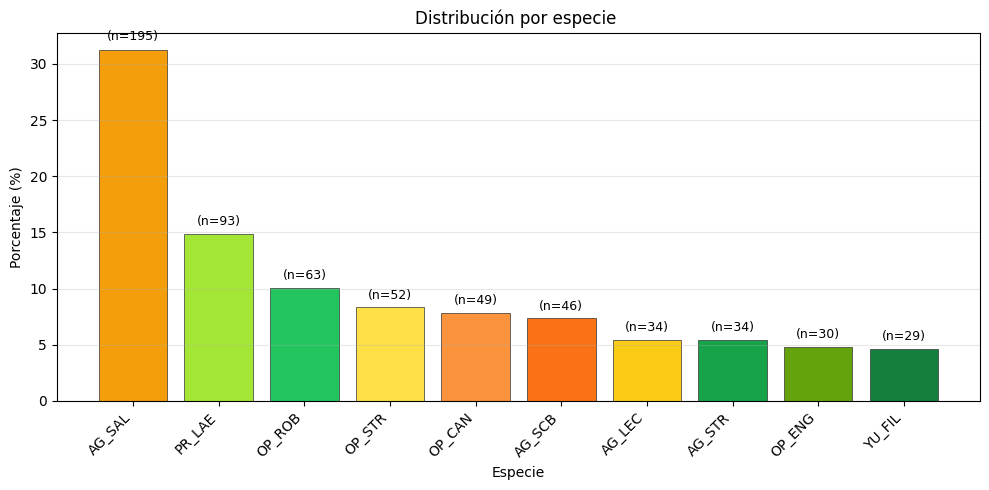

Guardados: composition_counts.csv y hist_porcentajes_especie.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

PALETTE = {
    "AG_SAL": "#F59E0B", "OP_ROB": "#22C55E", "OP_STR": "#FDE047",
    "OP_ENG": "#65A30D", "OP_CAN": "#FB923C", "PR_LAE": "#A3E635",
    "AG_LEC": "#FACC15", "AG_STR": "#16A34A", "AG_SCB": "#F97316",
    "YU_FIL": "#15803D",
}
DEFAULT_COLOR = "#999999"


df = pd.read_csv("assignments_pyomo.csv")
df["status"] = df["status"].str.lower().str.strip()
df["species_id"] = df["species_id"].astype(str).str.strip()
plot_df = df[(df["status"] != "blocked") & (df["species_id"] != "")].copy()


counts = (plot_df.groupby("species_id", as_index=False)
          .size()
          .rename(columns={"size":"count"}))
total = counts["count"].sum()
counts["percent"] = (counts["count"] / total) * 100
counts = counts.sort_values("percent", ascending=False).reset_index(drop=True)


counts.to_csv("composition_counts.csv", index=False)

print(counts.to_string(index=False, float_format=lambda x: f"{x:0.2f}"))

colors = [PALETTE.get(sp, DEFAULT_COLOR) for sp in counts["species_id"]]

plt.figure(figsize=(10, 5))
bars = plt.bar(counts["species_id"], counts["percent"], color=colors, edgecolor="#333333", linewidth=0.5)

plt.ylabel("Porcentaje (%)")
plt.xlabel("Especie")
plt.title("Distribución por especie ")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)


for bar, cnt in zip(bars, counts["count"]):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + max(0.5, 0.02*y),
             f"(n={cnt})",
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("hist_porcentajes_especie.png", dpi=200)
plt.show()

print("Guardados: composition_counts.csv y hist_porcentajes_especie.png")


species_id  expected_count  final_count  diff_count  expected_percent  final_percent  diff_percent  lower_percent  upper_percent  in_band
    AG_LEC           39.89           34       -5.89              6.38           5.44         -0.94           5.29           7.48     True
    AG_SAL          186.17          195        8.83             29.79          31.20          1.41          28.28          31.30     True
    AG_SCB           39.89           46        6.11              6.38           7.36          0.98           5.33           7.44     True
    AG_STR           39.89           34       -5.89              6.38           5.44         -0.94           5.29           7.47     True
    OP_CAN           46.54           49        2.46              7.45           7.84          0.39           6.38           8.52     True
    OP_ENG           36.09           30       -6.09              5.78           4.80         -0.98           4.79           6.76     True
    OP_ROB           69.34        

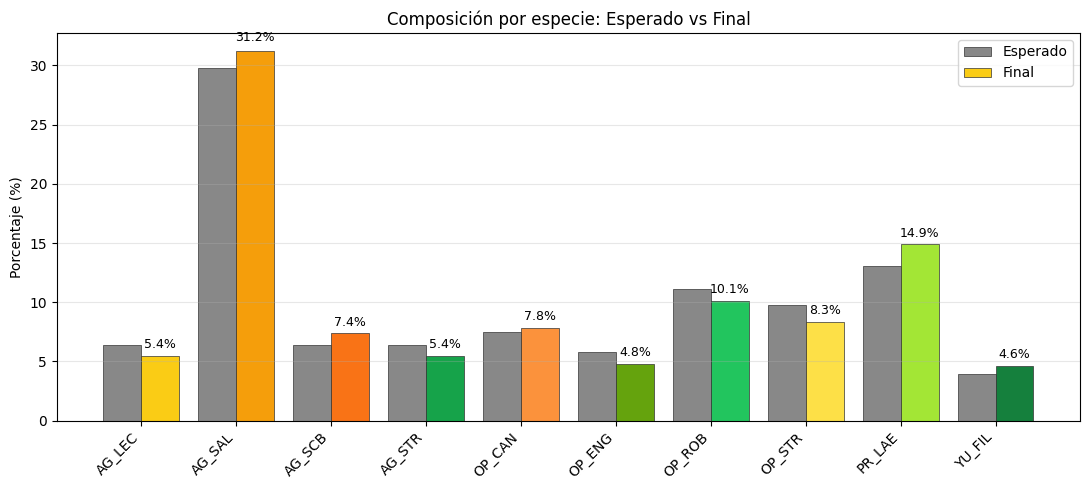

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

PALETTE = {
    "AG_SAL": "#F59E0B","OP_ROB": "#22C55E","OP_STR": "#FDE047","OP_ENG": "#65A30D",
    "OP_CAN": "#FB923C","PR_LAE": "#A3E635","AG_LEC": "#FACC15","AG_STR": "#16A34A",
    "AG_SCB": "#F97316","YU_FIL": "#15803D"
}
DEFAULT_COLOR = "#999999"


SPECIES_IDS = ["AG_LEC","AG_SAL","AG_SCB","AG_STR","OP_CAN","OP_ENG","OP_ROB","OP_STR","PR_LAE","YU_FIL"]

assign  = pd.read_csv("assignments_pyomo.csv")
targets = pd.read_csv("species_targets.csv")  # species_id,f_target,v_tol


assign["status"] = assign["status"].str.lower().str.strip()
assign["species_id"] = assign["species_id"].astype(str).str.strip()
plot_df = assign[(assign["status"] != "blocked") & (assign["species_id"] != "")]
T = len(plot_df)


final_counts = (plot_df.groupby("species_id", as_index=False)
                .size().rename(columns={"size":"final_count"}))


df = (targets.copy()
      .assign(species_id=lambda d: d["species_id"].astype(str).str.strip())
      .set_index("species_id").reindex(SPECIES_IDS).reset_index())

df = df.merge(final_counts, on="species_id", how="left").fillna({"final_count":0})


df["expected_count"]   = df["f_target"] * T
df["expected_percent"] = df["f_target"] * 100
df["v_tol_percent"]    = df["v_tol"] * 100
df["lower_percent"]    = (df["f_target"] - df["v_tol"]) * 100
df["upper_percent"]    = (df["f_target"] + df["v_tol"]) * 100
df["final_percent"]    = (df["final_count"] / T) * 100
df["diff_count"]       = df["final_count"] - df["expected_count"]
df["diff_percent"]     = df["final_percent"] - df["expected_percent"]
df["in_band"]          = (df["final_percent"] >= df["lower_percent"]) & (df["final_percent"] <= df["upper_percent"])


cols_show = ["species_id","expected_count","final_count","diff_count",
             "expected_percent","final_percent","diff_percent","lower_percent","upper_percent","in_band"]
print(df[cols_show].round(2).to_string(index=False))
df.round(4).to_csv("composition_expected_vs_final.csv", index=False)
print("Guardado: composition_expected_vs_final.csv")

x = np.arange(len(df))
w = 0.4

fig, ax = plt.subplots(figsize=(11, 5))

ax.bar(x - w/2, df["expected_percent"], width=w, label="Esperado", color="#888888", edgecolor="#333333", linewidth=0.5)
colors = [PALETTE.get(sp, DEFAULT_COLOR) for sp in df["species_id"]]
bars = ax.bar(x + w/2, df["final_percent"], width=w, label="Final", color=colors, edgecolor="#333333", linewidth=0.5)


for bar, pct in zip(bars, df["final_percent"]):
    y = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2, y + max(0.4, 0.02*y), f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x, df["species_id"], rotation=45, ha="right")
ax.set_ylabel("Porcentaje (%)")
ax.set_title("Composición por especie: Esperado vs Final")
ax.grid(axis="y", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig("comparacion_esperado_vs_final.png", dpi=200)
plt.show()
